# Audio2Piano Demo

## 1. Import the transcriber and utility functions

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("src").resolve()))

from audio2piano import Audio2Piano, note_matrices_to_notes
from utils import show_spectrogram, show_piano_roll, midi_to_sustain_roll

import torch


## 2. Initialize the Transcriber

In [2]:
transcriber = Audio2Piano("weights/model_weights.pth")

## 3. Visualize Transcription Steps

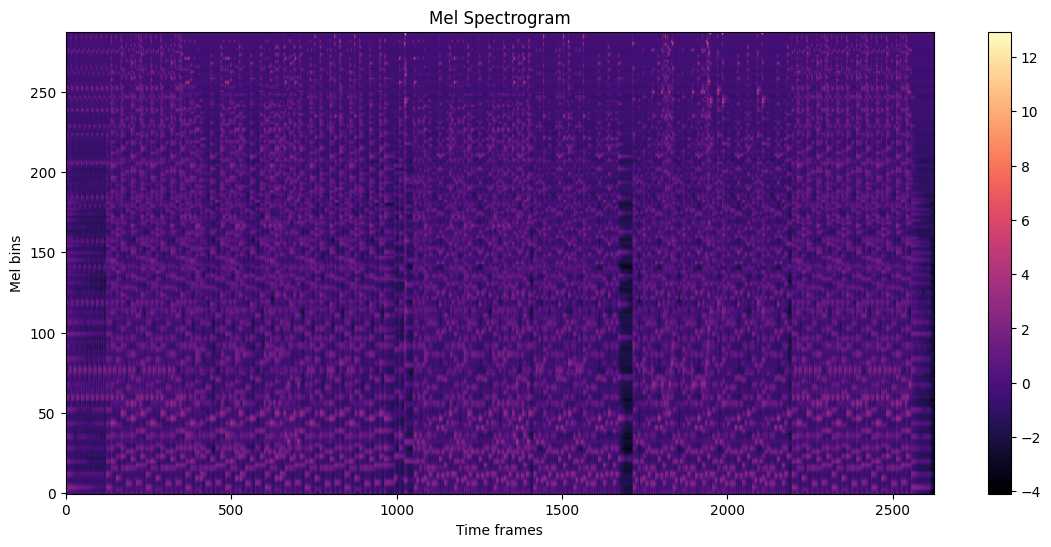

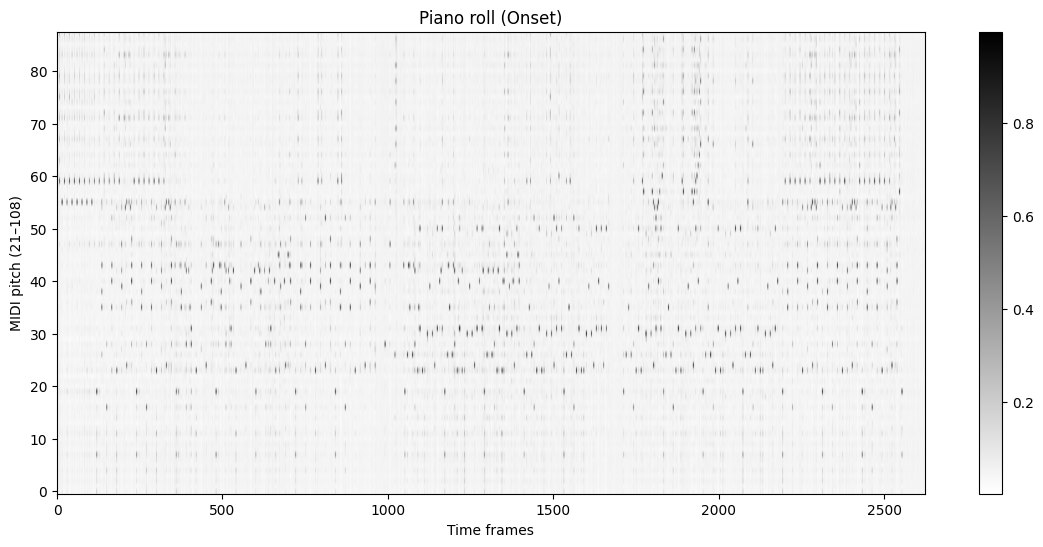

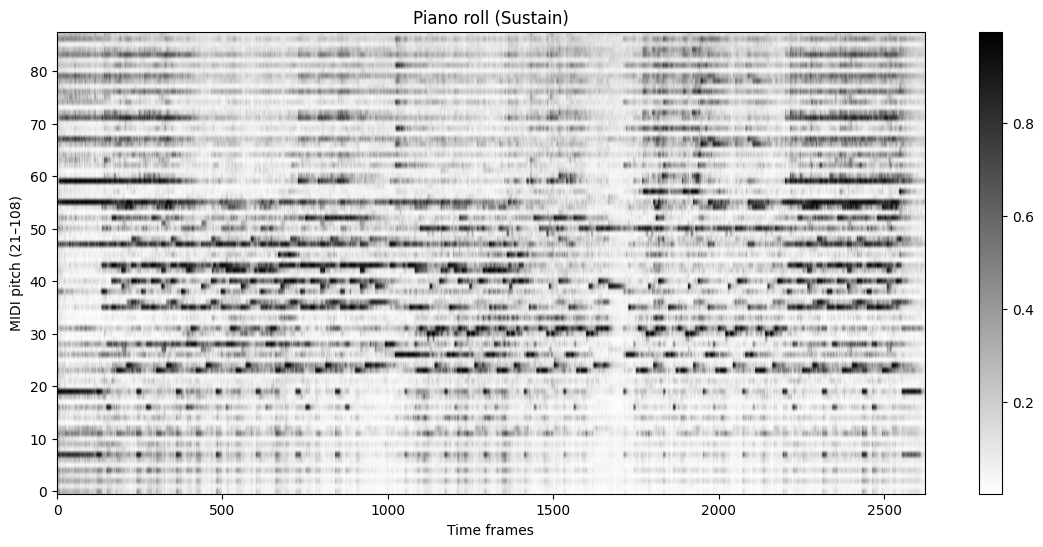

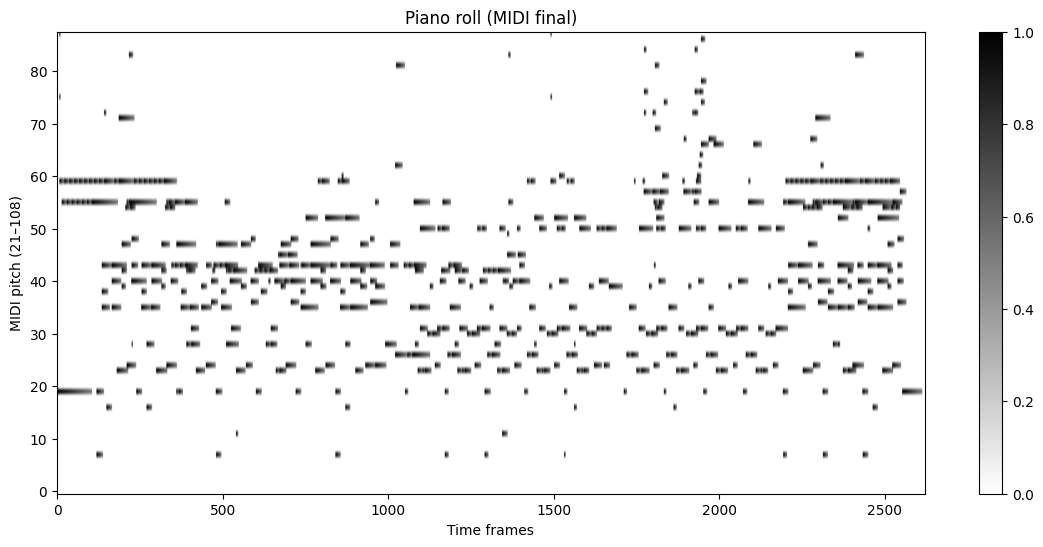

In [3]:
WAV_FILE = "data/musics/wav(input)/example1.wav"
THRESHOLD = 0.6

samples, sr = transcriber.load_wav(WAV_FILE)
mels = transcriber.wav_to_mel(samples, sr)

show_spectrogram(mels, "Mel Spectrogram", "Mel bins")


x = mels.T.detach().unsqueeze(0).float().to(transcriber.device)
onset_logits, sustain_logits = transcriber.forward(x)
onset_probs = torch.sigmoid(onset_logits)[0].cpu().detach().numpy()
sustain_probs = torch.sigmoid(sustain_logits)[0].cpu().detach().numpy()

show_piano_roll(onset_probs, "Piano roll (Onset)")
show_piano_roll(sustain_probs, "Piano roll (Sustain)")


duration = len(samples) / sr
total_steps = int(duration / 0.05) + 1
notes = note_matrices_to_notes(onset_matrix=onset_probs, sustain_matrix=sustain_probs, onset_threshold=THRESHOLD)
midi_matrix = midi_to_sustain_roll(notes, total_steps=total_steps)

show_piano_roll(midi_matrix, "Piano roll (MIDI final)")

## 4. Convert a Single WAV File into a MIDI File

In [4]:
WAV_FILE = "data/musics/wav(input)/example0.wav"
OUTPUT_FILE = "data/musics/midi(output)/example0.mid"

midi = transcriber.wav_to_midi_file(WAV_FILE, OUTPUT_FILE)

## 5. Convert an Entire WAV Folder into a MIDI Folder

In [8]:
WAV_FOLDER = "data/musics/wav(input)"
OUTPUT_FOLDER = "data/musics/midi(output)"

midi = transcriber.wav_to_midi_folder(WAV_FOLDER, OUTPUT_FOLDER)

[INFO] Found 6 WAV files. Converting to MIDI...
Converting: data\musics\wav(input)\example0.wav → data\musics\midi(output)\example0.mid
Converting: data\musics\wav(input)\example1.wav → data\musics\midi(output)\example1.mid
Converting: data\musics\wav(input)\example2.wav → data\musics\midi(output)\example2.mid
Converting: data\musics\wav(input)\example3.wav → data\musics\midi(output)\example3.mid
Converting: data\musics\wav(input)\example4.wav → data\musics\midi(output)\example4.mid
Converting: data\musics\wav(input)\example5.wav → data\musics\midi(output)\example5.mid
[OK] All files processed.
